# 13__fimo_v_mind
# comparing ChIP overlap b/w FIMO and MIND

in this notebook, i compare the accuracy of FIMO and MIND by comparing how often hits from either one overlap with known ChIP-seq peaks. 

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import time

from os import walk
from scipy.stats import spearmanr

# import utils
sys.path.append("../../utils")
from plotting_utils import *
from misc_utils import *
from norm_utils import *

%matplotlib inline

In [2]:
sns.set(**PAPER_PRESET)
fontsize = PAPER_FONTSIZE

## variables

In [3]:
chip_dir = "../../misc/07__chip"

In [4]:
hepg2_motif_dir = "../../data/06__mind_results/HepG2/files/1__motif_scores"
k562_motif_dir = "../../data/06__mind_results/K562/files/1__motif_scores"

In [5]:
fimo_f = "../../misc/05__fimo/pool2.fimo.txt"

In [6]:
index_f = "../../data/00__index/dels_oligo_pool.index.txt"

In [7]:
del_buffer = 10
fdr_cutoff = 0.05

## 1. import data

In [8]:
hepg2_files = []
for (dirpath, dirnames, filenames) in walk(hepg2_motif_dir):
    hepg2_files.extend(filenames)
    break
hepg2_files = [x for x in hepg2_files if "loss__results" in x and "expr_filt" not in x]
hepg2_files[0:5]

['enhancer_NEAT1__pX__tile2__minus__peak1.loss__results.txt',
 'enhancer_NEAT1__pX__tile2__minus__peak2.loss__results.txt',
 'enhancer_MALAT1__pX__tile2__minus__peak1.loss__results.txt',
 'enhancer_MALAT1__pX__tile2__minus__peak2.loss__results.txt',
 'enhancer_MALAT1__pX__tile2__minus__peak3.loss__results.txt']

In [9]:
k562_files = []
for (dirpath, dirnames, filenames) in walk(k562_motif_dir):
    k562_files.extend(filenames)
    break
k562_files = [x for x in k562_files if "loss__results" in x and "expr_filt" not in x]
k562_files[0:5]

['enhancer_MALAT1__pX__tile1__minus__peak1.loss__results.txt',
 'enhancer_MALAT1__pX__tile2__minus__peak1.loss__results.txt',
 'enhancer_MALAT1__pX__tile2__minus__peak2.loss__results.txt',
 'FALEC__p1__tile2__plus__peak1.loss__results.txt',
 'GAS5__p1__tile2__minus__peak1.loss__results.txt']

In [10]:
fimo = pd.read_table(fimo_f, sep="\t")
fimo.head()

,#pattern name,sequence name,start,stop,strand,score,p-value,q-value,matched sequence
0,ZNF263,WILDTYPE_BUT_HAS_SNP_DELETION__Lincrna.noflip....,39,59,-,27.0204,4.070000e-11,0.000024,GGAGGAGGGAGGGGAGGGGAG
1,ZNF263,WILDTYPE_SNP_INDIV__mrna.noflip.NA__p1@IRX5__c...,24,44,+,26.6735,6.730000e-11,0.000024,GGAGGAGGAAGAGGGAGAGGG
2,RREB1,WILDTYPE_BUT_HAS_SNP_DELETION__mrna.flip.sense...,24,43,-,27.0550,3.310000e-10,0.000043,CCCCACCCCACCCCCACCCC
3,RREB1,FLIPPED_DELETION__mrna.flip.antisense__p1@CDKN...,71,90,+,27.0550,3.310000e-10,0.000043,CCCCACCCCACCCCCACCCC
4,ZNF263,WILDTYPE_BUT_HAS_SNP_DELETION__Lincrna.noflip....,38,58,-,25.3878,3.590000e-10,0.000024,GAGGGAGGGAGGGGAGGGGGG


In [11]:
index = pd.read_table(index_f, sep="\t")
index.head()

,full_oligo,oligo_type,oligo_id,dupe_info,seq_name,tile_name,chr,locus_start,locus_end,strand,...,tile_number,local_start,local_end,RE_count_1,RE_count_2,RE_count_3,SNP,barcode,element,unique_id
0,ACTGGCCGCTTCACTGTGTTCCAGAAAACAGCAGCAAACAGAGGCC...,WILDTYPE_BUT_HAS_SNP,1.2.0.0.0.0.1,none,Enhancer.noflip.NA__chr11:65187297-65188198__c...,Enhancer.noflip.NA__chr11:65187297-65188198__c...,chr11,65187510.0,65187718.0,-,...,2.0,94.0,208.0,1,1,0,none,GATTCGTCGTG,TGTTCCAGAAAACAGCAGCAAACAGAGGCCCTTGGATTCCGGGGTG...,WILDTYPE_BUT_HAS_SNP__Enhancer.noflip.NA__chr1...
1,ACTGGCCGCTTCACTGTGTTCCAGAAAACAGCAGCAAACAGAGGCC...,WILDTYPE_BUT_HAS_SNP,1.2.0.0.0.0.2,none,Enhancer.noflip.NA__chr11:65187297-65188198__c...,Enhancer.noflip.NA__chr11:65187297-65188198__c...,chr11,65187510.0,65187718.0,-,...,2.0,94.0,208.0,1,1,0,none,CGAGATAAGTT,TGTTCCAGAAAACAGCAGCAAACAGAGGCCCTTGGATTCCGGGGTG...,WILDTYPE_BUT_HAS_SNP__Enhancer.noflip.NA__chr1...
2,ACTGGCCGCTTCACTGTGTTCCAGAAAACAGCAGCAAACAGAGGCC...,WILDTYPE_BUT_HAS_SNP,1.2.0.0.0.0.3,none,Enhancer.noflip.NA__chr11:65187297-65188198__c...,Enhancer.noflip.NA__chr11:65187297-65188198__c...,chr11,65187510.0,65187718.0,-,...,2.0,94.0,208.0,1,1,0,none,CTCGATTAAGG,TGTTCCAGAAAACAGCAGCAAACAGAGGCCCTTGGATTCCGGGGTG...,WILDTYPE_BUT_HAS_SNP__Enhancer.noflip.NA__chr1...
3,ACTGGCCGCTTCACTGTGTTCCAGAAAACAGCAGCAAACAGAGGCC...,WILDTYPE_BUT_HAS_SNP,1.2.0.0.0.0.4,none,Enhancer.noflip.NA__chr11:65187297-65188198__c...,Enhancer.noflip.NA__chr11:65187297-65188198__c...,chr11,65187510.0,65187718.0,-,...,2.0,94.0,208.0,1,1,0,none,TGAATAAGTCA,TGTTCCAGAAAACAGCAGCAAACAGAGGCCCTTGGATTCCGGGGTG...,WILDTYPE_BUT_HAS_SNP__Enhancer.noflip.NA__chr1...
4,ACTGGCCGCTTCACTGTGTTCCAGAAAACAGCAGCAAACAGAGGCC...,WILDTYPE_BUT_HAS_SNP,1.2.0.0.0.0.5,none,Enhancer.noflip.NA__chr11:65187297-65188198__c...,Enhancer.noflip.NA__chr11:65187297-65188198__c...,chr11,65187510.0,65187718.0,-,...,2.0,94.0,208.0,1,1,0,none,CCTAATCGACA,TGTTCCAGAAAACAGCAGCAAACAGAGGCCCTTGGATTCCGGGGTG...,WILDTYPE_BUT_HAS_SNP__Enhancer.noflip.NA__chr1...


## 2. find motifs < 0.05 FDR & put in terms of absolute coords

In [12]:
hepg2_data = {}
for f in hepg2_files:
    name = f.split(".")[0]
    df = pd.read_table("%s/%s" % (hepg2_motif_dir, f), sep="\t")
    hepg2_data[name] = df
    #print("%s: min motif nuc: %s, max motif nuc: %s" % (name, df["start"].min(), df["end"].max()))
hepg2_data["GAS5__p1__tile2__minus__peak1"].head()

,motif,start,end,score,pval,tile_chr,tile_start,tile_end,strand,padj,neg_log_pval,fdr_cutoff
0,CREB1,20,28,6.794534,0.0001,chr1,173837092.0,173837206.0,antisense,0.002256,2.646604,0.05
1,Gmeb1,15,32,6.216823,0.0020,chr1,173837092.0,173837206.0,antisense,0.020562,1.686933,0.05
2,Creb5,18,30,6.029732,0.0001,chr1,173837092.0,173837206.0,antisense,0.002256,2.646604,0.05
3,Atf3,22,30,6.001356,0.0001,chr1,173837092.0,173837206.0,antisense,0.002256,2.646604,0.05
4,Crem,20,30,5.974204,0.0001,chr1,173837092.0,173837206.0,antisense,0.002256,2.646604,0.05


In [13]:
k562_data = {}
for f in k562_files:
    name = f.split(".")[0]
    df = pd.read_table("%s/%s" % (k562_motif_dir, f), sep="\t")
    k562_data[name] = df
    #print("%s: min motif nuc: %s, max motif nuc: %s" % (name, df["start"].min(), df["end"].max()))
k562_data["GAS5__p1__tile2__minus__peak1"].head()

,motif,start,end,score,pval,tile_chr,tile_start,tile_end,strand,padj,neg_log_pval,fdr_cutoff
0,CREB1,20,28,6.356575,0.0001,chr1,173837092.0,173837206.0,antisense,0.003707,2.431004,0.05
1,Gmeb1,15,32,5.702321,0.0028,chr1,173837092.0,173837206.0,antisense,0.044032,1.356232,0.05
2,Creb5,18,30,5.651505,0.0001,chr1,173837092.0,173837206.0,antisense,0.003707,2.431004,0.05
3,Atf3,22,30,5.539003,0.0001,chr1,173837092.0,173837206.0,antisense,0.003707,2.431004,0.05
4,ATF7,17,31,5.538545,0.0001,chr1,173837092.0,173837206.0,antisense,0.003707,2.431004,0.05


In [14]:
def get_strand(row):
    if row["strand"] == "sense":
        return "+"
    else:
        return "-"

In [15]:
hepg2_all_motifs = pd.DataFrame()
hepg2_top5_motifs = pd.DataFrame()
for name in hepg2_data:
    df = hepg2_data[name]

    if "plus" in name:
        df["motif_start"] = df["tile_start"].astype(int) + del_buffer + df["start"].astype(int) - 1
        df["motif_end"] = df["tile_start"].astype(int) + del_buffer + df["start"].astype(int) + (df["end"]-df["start"]).astype(int) - 1
    elif "minus" in name:
        df["motif_end"] = df["tile_end"].astype(int) - del_buffer - df["start"].astype(int) + 1
        df["motif_start"] = df["motif_end"].astype(int) - (df["end"]-df["start"]).astype(int)
        
    # limit to motifs < fdr cutoff
    fdr = df["fdr_cutoff"].iloc[0]
    sig_motifs = df[df["padj"] < fdr]
    sig_motifs["gene"] = name
    sig_motifs["id"] = sig_motifs["motif"].astype(str) + "__" + sig_motifs["tile_chr"].astype(str) + "__" + sig_motifs["motif_start"].astype(str)
    
    # for other analysis - limit to top 5
    top5_motifs = sig_motifs.sort_values(by="score", ascending=False).head(5)
    
    hepg2_all_motifs = hepg2_all_motifs.append(sig_motifs)
    hepg2_top5_motifs = hepg2_top5_motifs.append(top5_motifs)

hepg2_all_motifs["strand"] = hepg2_all_motifs.apply(get_strand, axis=1)
hepg2_all_motifs = hepg2_all_motifs[["tile_chr", "motif_start", "motif_end", "motif", "score", "strand", "gene", "id"]]
hepg2_all_motifs = hepg2_all_motifs.drop_duplicates()
hepg2_all_motifs.sample(5)

,tile_chr,motif_start,motif_end,motif,score,strand,gene,id
1,chrX,73164056,73164070,Tcf21,2.599636,+,JPX__p1__tile1__plus__peak1,Tcf21__chrX__73164056
132,chr1,173837165,173837173,FOXO3,2.235314,+,GAS5__p1__tile2__minus__peak1,FOXO3__chr1__173837165
6,chr1,211556062,211556072,ETV4,4.871526,+,LINC00467__p1__tile1__plus__peak1,ETV4__chr1__211556062
16,chr3,169482983,169482993,NFATC1,5.952807,-,TERC__p1__tile1__minus__peak1,NFATC1__chr3__169482983
9,chr14,101292392,101292407,JUND(var.2),4.699084,-,MEG3__p1__tile2__plus__peak1,JUND(var.2)__chr14__101292392


In [16]:
k562_all_motifs = pd.DataFrame()
k562_top5_motifs = pd.DataFrame()

for name in k562_data:
    df = k562_data[name]

    if "plus" in name:
        df["motif_start"] = df["tile_start"].astype(int) + del_buffer + df["start"].astype(int) - 1
        df["motif_end"] = df["tile_start"].astype(int) + del_buffer + df["start"].astype(int) + (df["end"]-df["start"]).astype(int) - 1
    elif "minus" in name:
        df["motif_end"] = df["tile_end"].astype(int) - del_buffer - df["start"].astype(int) + 1
        df["motif_start"] = df["motif_end"].astype(int) - (df["end"]-df["start"]).astype(int)
        
    # limit to motifs < 0.05
    fdr = df["fdr_cutoff"].iloc[0]
    sig_motifs = df[df["padj"] < fdr]
    sig_motifs["gene"] = name
    sig_motifs["id"] = sig_motifs["motif"].astype(str) + "__" + sig_motifs["tile_chr"].astype(str) + "__" + sig_motifs["motif_start"].astype(str)
    
    # for other analysis - limit to top 5
    top5_motifs = sig_motifs.sort_values(by="score", ascending=False).head(5)
    
    k562_all_motifs = k562_all_motifs.append(sig_motifs)
    k562_top5_motifs = k562_top5_motifs.append(top5_motifs)

k562_all_motifs["strand"] = k562_all_motifs.apply(get_strand, axis=1)
k562_all_motifs = k562_all_motifs[["tile_chr", "motif_start", "motif_end", "motif", "score", "strand", "gene", "id"]]
k562_all_motifs = k562_all_motifs.drop_duplicates()
k562_all_motifs.sample(5)

,tile_chr,motif_start,motif_end,motif,score,strand,gene,id
53,chr1,173837495,173837508,HSF1,2.835706,+,ZBTB37__p1__tile2__plus__peak2,HSF1__chr1__173837495
8,chr7,130794785,130794796,JUNB,4.021405,+,LINC_PINT__p2__tile1__minus__peak1,JUNB__chr7__130794785
10,chr5,90610261,90610269,Pax2,5.744323,+,LUCAT1__p1__tile2__minus__peak1,Pax2__chr5__90610261
37,chr3,70048830,70048842,GLI2,2.816638,+,SAMMSON__p1__tile2__plus__peak1,GLI2__chr3__70048830
25,chr1,173837493,173837504,Stat5a::Stat5b,4.157354,+,ZBTB37__p1__tile2__plus__peak2,Stat5a::Stat5b__chr1__173837493


In [17]:
hepg2_all_motifs["cell_type"] = "HepG2"
k562_all_motifs["cell_type"] = "K562"
all_motifs = hepg2_all_motifs.append(k562_all_motifs)

In [18]:
len(all_motifs)

1063

## same for fimo

In [19]:
fimo_wt = fimo[~(fimo["sequence name"].str.contains("DELETION")) & 
               ~(fimo["sequence name"].str.contains("SNP_INDIV"))]
fimo_wt.sample(5)

,#pattern name,sequence name,start,stop,strand,score,p-value,q-value,matched sequence
105564,RREB1,WILDTYPE_BUT_HAS_SNP__mrna.noflip.NA__p1@ZBTB3...,64,83,-,2.63303,0.000094,0.0181,CCCCCCCTTCCCCCATCCCC
56914,TFAP2A(var.3),WILDTYPE_BUT_HAS_SNP__mrna.flip.sense__p1@CDKN...,92,104,+,11.65570,0.000038,0.0401,CGCCTGCGGGGCG
90986,NR2C2,FLIPPED__mrna.flip.antisense__p1@CDKN2A__chr9:...,54,68,-,9.05714,0.000077,0.0823,GGGGGTGAAGGTGGG
102940,TFAP2A(var.3),FLIPPED__Lincrna.flip.antisense__p1@LOC400550_...,66,78,-,9.60656,0.000090,0.0484,TGCCCCTGTGGGC
102979,KLF14,WILDTYPE_BUT_HAS_SNP__mrna.noflip.NA__p1@ZBTB3...,37,50,-,8.01724,0.000090,0.0871,CCTCGCGCCCCCTC


In [20]:
fimo_wt = fimo_wt.merge(index[["unique_id", "chr", "tile_start", "tile_end"]].drop_duplicates(), 
                        left_on="sequence name", right_on="unique_id")
fimo_wt.sample(5)

,#pattern name,sequence name,start,stop,strand,score,p-value,q-value,matched sequence,unique_id,chr,tile_start,tile_end
898,KLF16,WILDTYPE_BUT_HAS_SNP__Lincrna.flip.sense__p1@L...,21,31,-,10.4138,0.000071,0.01850,CCAACTCCCCC,WILDTYPE_BUT_HAS_SNP__Lincrna.flip.sense__p1@L...,chr16,86542457.0,86542571.0
1042,FOXD1,FLIPPED__Lincrna.flip.antisense__p1@LOC400550_...,58,65,-,13.3300,0.000044,0.34000,GTAAACAA,FLIPPED__Lincrna.flip.antisense__p1@LOC400550_...,chr16,86542551.0,86542665.0
1738,ZBTB7C,WILDTYPE_BUT_HAS_SNP__Lincrna.noflip.NA__p1@TE...,102,113,-,10.7419,0.000092,0.17000,GCCACCACCCCT,WILDTYPE_BUT_HAS_SNP__Lincrna.noflip.NA__p1@TE...,chr3,169482812.0,169482926.0
1725,NFYB,WILDTYPE_BUT_HAS_SNP__Lincrna.noflip.NA__p1@TE...,14,28,+,11.5192,0.000046,0.30000,AGCTTGGCCAATCCG,WILDTYPE_BUT_HAS_SNP__Lincrna.noflip.NA__p1@TE...,chr3,169482812.0,169482926.0
1083,EGR1,WILDTYPE__Antisense.noflip.NA__p2@FLJ43663__ch...,16,29,+,15.9615,0.000002,0.00168,CCGCCGCCGCCTCC,WILDTYPE__Antisense.noflip.NA__p2@FLJ43663__ch...,chr7,130794716.0,130794830.0


In [21]:
fimo_wt["motif_start"] = fimo_wt["tile_start"].astype(int) + fimo_wt["start"].astype(int) - 1
fimo_wt["motif_end"] = fimo_wt["tile_start"].astype(int) + fimo_wt["stop"].astype(int)
fimo_wt["id"] = fimo_wt["#pattern name"] + "__" + fimo_wt["chr"] + "__" + fimo_wt["motif_start"].astype(str)
fimo_wt.sample(5)

,#pattern name,sequence name,start,stop,strand,score,p-value,q-value,matched sequence,unique_id,chr,tile_start,tile_end,motif_start,motif_end,id
1730,ZIC3,WILDTYPE_BUT_HAS_SNP__Lincrna.noflip.NA__p1@TE...,72,86,-,8.6000,0.000056,0.05910,CGCAACCCGGTGCGC,WILDTYPE_BUT_HAS_SNP__Lincrna.noflip.NA__p1@TE...,chr3,169482812.0,169482926.0,169482883,169482898,ZIC3__chr3__169482883
1595,STAT1::STAT2,WILDTYPE_BUT_HAS_SNP__Lincrna.noflip.NA__p1@MA...,3,17,-,11.1818,0.000033,0.14400,CTAGTTTTACTTTTC,WILDTYPE_BUT_HAS_SNP__Lincrna.noflip.NA__p1@MA...,chr11,65266377.0,65266491.0,65266379,65266394,STAT1::STAT2__chr11__65266379
179,NRF1,FLIPPED__mrna.flip.antisense__p1@CDKN2A__chr9:...,44,54,+,11.5455,0.000036,0.00923,GCGCCCGCCCC,FLIPPED__mrna.flip.antisense__p1@CDKN2A__chr9:...,chr9,21994446.0,21994560.0,21994489,21994500,NRF1__chr9__21994489
16,TFAP2C(var.2),WILDTYPE_BUT_HAS_SNP__Lincrna.noflip.NA__p1@LI...,75,85,-,14.3077,0.000007,0.01930,AGCCTTAGGCA,WILDTYPE_BUT_HAS_SNP__Lincrna.noflip.NA__p1@LI...,chr1,211555971.0,211556085.0,211556045,211556056,TFAP2C(var.2)__chr1__211556045
557,SP1,"WILDTYPE__Antisense.flip.sense__p1@CDKN2B-AS,p...",66,76,+,15.8462,0.000002,0.00220,CCCCCACCCCC,"WILDTYPE__Antisense.flip.sense__p1@CDKN2B-AS,p...",chr9,21994622.0,21994736.0,21994687,21994698,SP1__chr9__21994687


In [22]:
fimo_bed = fimo_wt[["chr", "motif_start", "motif_end", "#pattern name", "score", "strand", "sequence name", "id"]]
fimo_bed.columns = ["tile_chr", "motif_start", "motif_end", "motif", "score", "strand", "gene", "id"]
fimo_bed.head()

,tile_chr,motif_start,motif_end,motif,score,strand,gene,id
0,chr1,211556009,211556030,ZNF263,23.8367,-,WILDTYPE_BUT_HAS_SNP__Lincrna.noflip.NA__p1@LI...,ZNF263__chr1__211556009
1,chr1,211556005,211556026,ZNF263,22.1429,-,WILDTYPE_BUT_HAS_SNP__Lincrna.noflip.NA__p1@LI...,ZNF263__chr1__211556005
2,chr1,211556000,211556015,SP2,18.7241,+,WILDTYPE_BUT_HAS_SNP__Lincrna.noflip.NA__p1@LI...,SP2__chr1__211556000
3,chr1,211556000,211556021,ZNF263,18.4082,-,WILDTYPE_BUT_HAS_SNP__Lincrna.noflip.NA__p1@LI...,ZNF263__chr1__211556000
4,chr1,211556000,211556011,SP1,16.7692,+,WILDTYPE_BUT_HAS_SNP__Lincrna.noflip.NA__p1@LI...,SP1__chr1__211556000


In [23]:
len(fimo_bed)

1759

In [24]:
# make df w/ a cell column
# since fimo = same across cell types, obviously, just repeat df
hepg2_fimo = fimo_bed.copy()
hepg2_fimo["cell_type"] = "HepG2"
k562_fimo = fimo_bed.copy()
k562_fimo["cell_type"] = "K562"
all_fimo = hepg2_fimo.append(k562_fimo)

## 3. intersect w/ bed files for cell type

In [25]:
chip_files = []
for (dirpath, dirnames, filenames) in walk(chip_dir):
    chip_files.extend(filenames)
    break

chip_files = [x for x in chip_files if "__" in x]
hepg2_chip_files = [x for x in chip_files if "HepG2" in x]
k562_chip_files = [x for x in chip_files if "K562" in x]
k562_chip_files[0:5]

['K562__ARID3A__narrowPeak_clean.bed.gz',
 'K562__ATF1__narrowPeak_clean.bed.gz',
 'K562__ATF3__narrowPeak_clean.bed.gz',
 'K562__BACH1__narrowPeak_clean.bed.gz',
 'K562__BCL3__narrowPeak_clean.bed.gz']

In [26]:
print("total chip files: %s" % (len(chip_files)))
print("total HepG2 chip files: %s" % (len(hepg2_chip_files)))
print("total K562 chip files: %s" % (len(k562_chip_files)))

total chip files: 539
total HepG2 chip files: 59
total K562 chip files: 100


In [27]:
hepg2_chip_motifs = [x.split("__")[1].upper() for x in hepg2_chip_files]
k562_chip_motifs = [x.split("__")[1].upper() for x in k562_chip_files]
chip_motifs = [x.split("__")[1].upper() for x in chip_files]
chip_motifs[0:5]

['ATF3', 'BCL3', 'BHLHE40', 'CEBPB', 'CREB1']

In [28]:
uniq_motifs = sorted(list(all_motifs["motif"].unique()))
len(uniq_motifs)

333

In [29]:
def get_overlap(row, int_ids):
    if row["id"] in int_ids:
        return "ChIP_overlap"
    else:
        return "no_overlap"

In [30]:
def intersect_chip_files(sub_df, chip_filename, colname):
    sub_df.to_csv("tmp.motifs.bed", sep="\t", index=False, header=False)
    !bedtools intersect -u -a tmp.motifs.bed -b $chip_filename > tmp.txt
    
    try:
        results = pd.read_table("tmp.txt", sep="\t", header=None)
        int_ids = list(results[7])
        sub_df[colname] = sub_df.apply(get_overlap, int_ids=int_ids, axis=1)
    except:
        sub_df[colname] = "no_overlap"
    return sub_df

In [31]:
def merge_and_intersect_chip_files(chip_files, motif, chip_dir, sub_df, colname):
    chip_files_sub = [x for x in chip_files if motif in x]
    chip_paths = ["%s/%s" % (chip_dir, x) for x in chip_files_sub]
    all_chip = pd.DataFrame()
    for f in chip_paths:
        tmp = pd.read_table(f, sep="\t", header=None)
        all_chip = all_chip.append(tmp)
    all_chip.to_csv("tmp.chip.bed", sep="\t", header=False, index=False)

    # intersect bed files
    sub_df = intersect_chip_files(sub_df, "tmp.chip.bed", colname)
    return sub_df

In [32]:
all_motifs_int = pd.DataFrame()
n_chip = 0
n_cell_chip = 0

for motif in uniq_motifs:
    print("=== %s ===" % motif)
    sub_df = all_motifs[all_motifs["motif"] == motif]
    
    # first check if these motifs overlap *any* chip peaks
    # sub_df = intersect_chip_files(sub_df, "%s/all.chip.bed.gz" % chip_dir, "any_chip_overlap")
    
    # force motif to upper
    motif_up = motif.upper()
    
    # see if that motif has been chipped at all
    if motif_up in chip_motifs:
        print("has been chipped")
        n_chip += 1

        sub_df = merge_and_intersect_chip_files(chip_files, motif_up, chip_dir, sub_df, "all_chip_overlap")
            
        # do both k562 & hepg2
        for cell, cell_chip_motifs, cell_chip_files in zip(["HepG2", "K562"], [hepg2_chip_motifs, k562_chip_motifs], [hepg2_chip_files, k562_chip_files]):
            cell_df = sub_df[sub_df["cell_type"] == cell]

            # now see if that motif has been chipped in cell type
            if motif_up in cell_chip_motifs:
                print("in %s" % cell)
                n_cell_chip += 1

                # find chip files and merge again
                cell_df = merge_and_intersect_chip_files(cell_chip_files, motif_up, chip_dir, cell_df, 
                                                        "cell_chip_overlap")
            else:
                cell_df["cell_chip_overlap"] = "no_ChIP"
            
            all_motifs_int = all_motifs_int.append(cell_df)
    else:
        sub_df["all_chip_overlap"] = "no_ChIP"
        sub_df["cell_chip_overlap"] = "no_ChIP"
        all_motifs_int = all_motifs_int.append(sub_df)

=== ARNT::HIF1A ===
=== ATF4 ===
=== ATF7 ===
=== Ahr::Arnt ===
=== Arid3a ===
has been chipped
in HepG2
in K562
=== Arid5a ===
=== Arnt ===
=== Arntl ===
=== Ascl2 ===
=== Atf1 ===
has been chipped
in K562
=== Atf3 ===
has been chipped
in HepG2
in K562
=== BARHL2 ===
=== BATF3 ===
=== BATF::JUN ===
=== BHLHE22 ===
=== BHLHE40 ===
has been chipped
in HepG2
in K562
=== BHLHE41 ===
=== Bach1::Mafk ===
=== Barhl1 ===
=== Bcl6 ===
=== CDX1 ===
=== CDX2 ===
=== CEBPB ===
has been chipped
in HepG2
in K562
=== CEBPD ===
has been chipped
in HepG2
=== CEBPE ===
=== CEBPG ===
=== CENPB ===
=== CREB1 ===
has been chipped
=== CREB3 ===
=== CREB3L1 ===
=== Creb3l2 ===
=== Creb5 ===
=== Crem ===
=== DBP ===
=== DLX6 ===
=== DUX4 ===
=== DUXA ===
=== Dlx3 ===
=== Dlx4 ===
=== Dux ===
=== E2F4 ===
has been chipped
in K562
=== E2F6 ===
has been chipped
in K562
=== E2F7 ===
=== E2F8 ===
=== EBF1 ===
has been chipped
=== EGR1 ===
has been chipped
in K562
=== EGR2 ===
=== EGR3 ===
=== EGR4 ===
=== EHF ===

In [33]:
all_motifs_int[all_motifs_int["motif"] == "NRF1"]

,tile_chr,motif_start,motif_end,motif,score,strand,gene,id,cell_type,all_chip_overlap,cell_chip_overlap
0,chr1,150488212,150488223,NRF1,7.971965,-,FALEC__p1__tile2__plus__peak1,NRF1__chr1__150488212,HepG2,ChIP_overlap,ChIP_overlap
2,chr1,211556129,211556140,NRF1,4.725896,+,LINC00467__p1__tile2__plus__peak5,NRF1__chr1__211556129,HepG2,ChIP_overlap,ChIP_overlap
1,chr13,50656265,50656276,NRF1,5.437629,+,DLEU1__p1__tile1__plus__peak2,NRF1__chr13__50656265,HepG2,ChIP_overlap,ChIP_overlap
1,chr13,50656306,50656317,NRF1,5.326211,+,DLEU1__p1__tile2__plus__peak1,NRF1__chr13__50656306,HepG2,ChIP_overlap,ChIP_overlap
8,chr13,50656376,50656387,NRF1,0.956409,+,DLEU1__p1__tile2__plus__peak2,NRF1__chr13__50656376,HepG2,ChIP_overlap,ChIP_overlap
10,chr16,86543256,86543267,NRF1,1.719780,-,FOXF1__p__tile2__plus__peak2,NRF1__chr16__86543256,HepG2,no_overlap,no_overlap
0,chr20,47895120,47895131,NRF1,9.380756,-,ZFAS1__p1__tile2__plus__peak1,NRF1__chr20__47895120,HepG2,ChIP_overlap,ChIP_overlap
3,chr1,150488212,150488223,NRF1,3.878904,-,FALEC__p1__tile2__plus__peak1,NRF1__chr1__150488212,K562,ChIP_overlap,ChIP_overlap
2,chr1,211556129,211556140,NRF1,3.518599,+,LINC00467__p1__tile2__plus__peak2,NRF1__chr1__211556129,K562,ChIP_overlap,ChIP_overlap
1,chr13,50656265,50656276,NRF1,3.648975,+,DLEU1__p1__tile1__plus__peak1,NRF1__chr13__50656265,K562,ChIP_overlap,no_overlap


## same for fimo

In [34]:
fimo_uniq_motifs = sorted(list(all_fimo["motif"].unique()))
len(fimo_uniq_motifs)

281

In [35]:
fimo_motifs_int = pd.DataFrame()
n_chip = 0
n_cell_chip = 0

for motif in fimo_uniq_motifs:
    print("=== %s ===" % motif)
    sub_df = all_fimo[all_fimo["motif"] == motif]
    
    # first check if these motifs overlap *any* chip peaks
    # sub_df = intersect_chip_files(sub_df, "%s/all.chip.bed.gz" % chip_dir, "any_chip_overlap")
    
    # force motif to upper
    motif_up = motif.upper()
    
    # see if that motif has been chipped at all
    if motif_up in chip_motifs:
        print("has been chipped")
        n_chip += 1

        sub_df = merge_and_intersect_chip_files(chip_files, motif_up, chip_dir, sub_df, "all_chip_overlap")
            
        # do both k562 & hepg2
        for cell, cell_chip_motifs, cell_chip_files in zip(["HepG2", "K562"], [hepg2_chip_motifs, k562_chip_motifs], [hepg2_chip_files, k562_chip_files]):
            cell_df = sub_df[sub_df["cell_type"] == cell]
            
            # now see if that motif has been chipped in cell type
            if motif_up in cell_chip_motifs:
                print("in %s" % cell)
                n_cell_chip += 1

                # find chip files and merge again
                cell_df = merge_and_intersect_chip_files(cell_chip_files, motif_up, chip_dir, cell_df, 
                                                         "cell_chip_overlap")
            else:
                cell_df["cell_chip_overlap"] = "no_ChIP"
            
            fimo_motifs_int = fimo_motifs_int.append(cell_df)
    else:
        sub_df["all_chip_overlap"] = "no_ChIP"
        sub_df["cell_chip_overlap"] = "no_ChIP"
        fimo_motifs_int = fimo_motifs_int.append(sub_df)

=== ARNT::HIF1A ===
=== ATF4 ===
=== ATF7 ===
=== Arntl ===
=== Ascl2 ===
=== Atf1 ===
has been chipped
in K562
=== Atf3 ===
has been chipped
in HepG2
in K562
=== BATF3 ===
=== BATF::JUN ===
=== Bach1::Mafk ===
=== Barhl1 ===
=== CDX1 ===
=== CDX2 ===
=== CEBPG ===
=== CREB1 ===
has been chipped
=== CREB3 ===
=== CREB3L1 ===
=== CTCF ===
has been chipped
in HepG2
in K562
=== CUX1 ===
=== CUX2 ===
=== Creb5 ===
=== Crem ===
=== Crx ===
=== DBP ===
=== Ddit3::Cebpa ===
=== Dlx4 ===
=== Dux ===
=== E2F4 ===
has been chipped
in K562
=== E2F6 ===
has been chipped
in K562
=== E2F7 ===
=== E2F8 ===
=== EBF1 ===
has been chipped
=== EGR1 ===
has been chipped
in K562
=== EGR2 ===
=== EGR3 ===
=== EGR4 ===
=== EHF ===
=== ELF1 ===
has been chipped
in HepG2
in K562
=== ELF3 ===
=== ELF4 ===
=== ELF5 ===
=== ELK1 ===
has been chipped
in K562
=== ELK3 ===
=== ELK4 ===
has been chipped
=== EOMES ===
=== ERF ===
=== ERG ===
=== ESR2 ===
=== ETS1 ===
has been chipped
in K562
=== ETV1 ===
=== ETV2 ===


In [36]:
fimo_motifs_int[fimo_motifs_int["motif"] == "NRF1"].head()

,tile_chr,motif_start,motif_end,motif,score,strand,gene,id,cell_type,all_chip_overlap,cell_chip_overlap
131,chr9,21994467,21994478,NRF1,14.9455,-,FLIPPED__mrna.flip.antisense__p1@CDKN2A__chr9:...,NRF1__chr9__21994467,HepG2,no_overlap,no_overlap
156,chr9,21994460,21994471,NRF1,12.6727,+,FLIPPED__mrna.flip.antisense__p1@CDKN2A__chr9:...,NRF1__chr9__21994460,HepG2,no_overlap,no_overlap
179,chr9,21994489,21994500,NRF1,11.5455,+,FLIPPED__mrna.flip.antisense__p1@CDKN2A__chr9:...,NRF1__chr9__21994489,HepG2,no_overlap,no_overlap
248,chr9,21994528,21994539,NRF1,14.9455,+,WILDTYPE_BUT_HAS_SNP__mrna.flip.sense__p1@CDKN...,NRF1__chr9__21994528,HepG2,no_overlap,no_overlap
273,chr9,21994535,21994546,NRF1,12.6727,-,WILDTYPE_BUT_HAS_SNP__mrna.flip.sense__p1@CDKN...,NRF1__chr9__21994535,HepG2,no_overlap,no_overlap


## 4. find numbers

In [37]:
cell_results = pd.pivot_table(all_motifs_int, values="id", index="cell_chip_overlap", columns="cell_type",
                              aggfunc="count").reset_index()
cell_results

cell_type,cell_chip_overlap,HepG2,K562
0,ChIP_overlap,37,36
1,no_ChIP,685,224
2,no_overlap,54,27


In [38]:
all_results = pd.pivot_table(all_motifs_int, values="id", index="all_chip_overlap", columns="cell_type",
                             aggfunc="count").reset_index()
all_results

cell_type,all_chip_overlap,HepG2,K562
0,ChIP_overlap,113,55
1,no_ChIP,585,202
2,no_overlap,78,30


In [39]:
cell_results_melt = pd.melt(cell_results, id_vars="cell_chip_overlap")
all_results_melt = pd.melt(all_results, id_vars="all_chip_overlap")

cell_results_melt = cell_results_melt[cell_results_melt["cell_chip_overlap"] != "no_ChIP"]
all_results_melt = all_results_melt[all_results_melt["all_chip_overlap"] != "no_ChIP"]

all_results_melt.head()

,all_chip_overlap,cell_type,value
0,ChIP_overlap,HepG2,113
2,no_overlap,HepG2,78
3,ChIP_overlap,K562,55
5,no_overlap,K562,30


In [40]:
cell_results_counts = cell_results_melt.groupby("cell_type")["value"].agg("sum").reset_index()
cell_results_melt = cell_results_melt.merge(cell_results_counts, on="cell_type", suffixes=("_count", "_total"))
cell_results_melt["percent"] = (cell_results_melt["value_count"]/cell_results_melt["value_total"])*100

all_results_counts = all_results_melt.groupby("cell_type")["value"].agg("sum").reset_index()
all_results_melt = all_results_melt.merge(all_results_counts, on="cell_type", suffixes=("_count", "_total"))
all_results_melt["percent"] = (all_results_melt["value_count"]/all_results_melt["value_total"])*100

all_results_melt.head()

,all_chip_overlap,cell_type,value_count,value_total,percent
0,ChIP_overlap,HepG2,113,191,59.162304
1,no_overlap,HepG2,78,191,40.837696
2,ChIP_overlap,K562,55,85,64.705882
3,no_overlap,K562,30,85,35.294118


In [41]:
cell_results_melt = cell_results_melt[cell_results_melt["cell_chip_overlap"] == "ChIP_overlap"]
cell_results_melt["type"] = "cell-type ChIP"
cell_results_melt = cell_results_melt[["type", "cell_type", "percent"]]

all_results_melt = all_results_melt[all_results_melt["all_chip_overlap"] == "ChIP_overlap"]
all_results_melt["type"] = "all ChIP"
all_results_melt = all_results_melt[["type", "cell_type", "percent"]]

results_melt = cell_results_melt.append(all_results_melt)
results_melt

,type,cell_type,percent
0,cell-type ChIP,HepG2,40.659341
2,cell-type ChIP,K562,57.142857
0,all ChIP,HepG2,59.162304
2,all ChIP,K562,64.705882


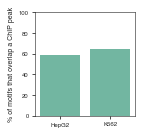

In [42]:
figs_dir = "figs/0__overlap_bar"
!mkdir -p $figs_dir

plt.figure(figsize=(1.8, 1.9))
sns.barplot(data=results_melt[results_melt["type"] == "all ChIP"], 
            x="cell_type", y="percent", color=sns.color_palette("Set2")[0])
plt.xlabel("")
plt.ylabel("% of motifs that overlap a ChIP peak")
plt.ylim((0, 100))
plt.savefig("%s/all_chip_overlap.pdf" % figs_dir, dpi="figure", bbox_inches="tight")

## same with fimo

In [43]:
cell_results = pd.pivot_table(fimo_motifs_int, values="id", index="cell_chip_overlap", columns="cell_type",
                              aggfunc="count").reset_index()
cell_results

cell_type,cell_chip_overlap,HepG2,K562
0,ChIP_overlap,61,132
1,no_ChIP,1475,1235
2,no_overlap,223,392


In [44]:
all_results = pd.pivot_table(fimo_motifs_int, values="id", index="all_chip_overlap", columns="cell_type",
                             aggfunc="count").reset_index()
all_results

cell_type,all_chip_overlap,HepG2,K562
0,ChIP_overlap,256,256
1,no_ChIP,1140,1140
2,no_overlap,363,363


In [45]:
cell_results_melt = pd.melt(cell_results, id_vars="cell_chip_overlap")
all_results_melt = pd.melt(all_results, id_vars="all_chip_overlap")

cell_results_melt = cell_results_melt[cell_results_melt["cell_chip_overlap"] != "no_ChIP"]
all_results_melt = all_results_melt[all_results_melt["all_chip_overlap"] != "no_ChIP"]

all_results_melt.head()

,all_chip_overlap,cell_type,value
0,ChIP_overlap,HepG2,256
2,no_overlap,HepG2,363
3,ChIP_overlap,K562,256
5,no_overlap,K562,363


In [46]:
cell_results_counts = cell_results_melt.groupby("cell_type")["value"].agg("sum").reset_index()
cell_results_melt = cell_results_melt.merge(cell_results_counts, on="cell_type", suffixes=("_count", "_total"))
cell_results_melt["percent"] = (cell_results_melt["value_count"]/cell_results_melt["value_total"])*100

all_results_counts = all_results_melt.groupby("cell_type")["value"].agg("sum").reset_index()
all_results_melt = all_results_melt.merge(all_results_counts, on="cell_type", suffixes=("_count", "_total"))
all_results_melt["percent"] = (all_results_melt["value_count"]/all_results_melt["value_total"])*100

all_results_melt.head()

,all_chip_overlap,cell_type,value_count,value_total,percent
0,ChIP_overlap,HepG2,256,619,41.357027
1,no_overlap,HepG2,363,619,58.642973
2,ChIP_overlap,K562,256,619,41.357027
3,no_overlap,K562,363,619,58.642973


In [47]:
cell_results_melt = cell_results_melt[cell_results_melt["cell_chip_overlap"] == "ChIP_overlap"]
cell_results_melt["type"] = "cell-type ChIP"
cell_results_melt = cell_results_melt[["type", "cell_type", "percent"]]

all_results_melt = all_results_melt[all_results_melt["all_chip_overlap"] == "ChIP_overlap"]
all_results_melt["type"] = "all ChIP"
all_results_melt = all_results_melt[["type", "cell_type", "percent"]]

results_melt = cell_results_melt.append(all_results_melt)
results_melt

,type,cell_type,percent
0,cell-type ChIP,HepG2,21.478873
2,cell-type ChIP,K562,25.190840
0,all ChIP,HepG2,41.357027
2,all ChIP,K562,41.357027


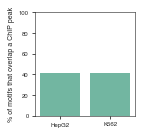

In [48]:
figs_dir = "figs/0__overlap_bar"
!mkdir -p $figs_dir

plt.figure(figsize=(1.8, 1.9))
sns.barplot(data=results_melt[results_melt["type"] == "all ChIP"], 
            x="cell_type", y="percent", color=sns.color_palette("Set2")[0])
plt.xlabel("")
plt.ylabel("% of motifs that overlap a ChIP peak")
plt.ylim((0, 100))
plt.savefig("%s/all_chip_overlap.fimo.pdf" % figs_dir, dpi="figure", bbox_inches="tight")